# 📊 Análise do Mercado de Banda Larga — ISPs no Brasil

## Contexto
Um fundo de investimento hipotético avalia entrar no mercado de banda larga brasileiro por meio da **aquisição de Provedores de Serviços de Internet (ISPs)**.  
O objetivo é entender o **potencial de crescimento** desse mercado, considerando **tecnologias** (Fibra, Cobre etc.) e **regiões** (UFs, macrorregiões e Brasil como um todo).

---

## Fontes de Dados
- **Anatel** — acessos de banda larga por município, empresa, tecnologia e velocidade.  
- **IBGE** — estatísticas de domicílios (totais e ocupados), população e densidade.  

Os dados foram processados em camadas:
- **RAW** → arquivos originais (CSV/Parquet).  
- **TRUSTED** → dados limpos e normalizados (Anatel particionado por ano/UF, IBGE consolidado).  


In [2]:
# =====================
# Imports
# =====================
import os, glob, gc, shutil
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

# Arrow para escrita incremental de Parquet
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# DuckDB para para o Merged dos arquivos Anatel
import duckdb, os

# Mapa de UF a partir do prefixo do código de município (IBGE)
UF_MAP = {
    11:'RO',12:'AC',13:'AM',14:'RR',15:'PA',16:'AP',17:'TO',
    21:'MA',22:'PI',23:'CE',24:'RN',25:'PB',26:'PE',27:'AL',
    28:'SE',29:'BA',31:'MG',32:'ES',33:'RJ',35:'SP',41:'PR',
    42:'SC',43:'RS',50:'MS',51:'MT',52:'GO',53:'DF'
}

# Colunas esperadas na Anatel (com base no exemplo)
ANATEL_COLS = [
    'cnpj','empresa','grupo_economico_anatel','porte_operadora_anatel','cod_mun',
    'faixa_de_velocidade','velocidade','tecnologia','meio_de_acesso','tipo_de_pessoa',
    'tipo_de_produto','banda_larga','data','grupo_tecnologia','grupo_economico',
    'grupo_operadora','porte_operadora','ano'
]

ANATEL_DTYPES_READ = {c:'string' for c in ANATEL_COLS}  # leitura robusta; convertemos depois

## Pipeline RAW para TRUSTED

**Anatel (CSV, 17 arquivos) e IBGE (Parquet)** — processamento **separado**, em **chunks** e gravação direta em **Parquet único** por fonte, para reduzir uso de memória.

- **RAW**: dados brutos (sem alterações)
- **TRUSTED**: dados limpos e consolidados  
  - `trusted/anatel/anatel_clean.parquet` (**um único arquivo**, gravado incrementalmente)
  - `trusted/ibge/ibge_domicilios_clean.parquet` (**um único arquivo**, gravado incrementalmente)

In [ ]:
# =====================
# Configuração
# =====================

# >>> Ajuste estes caminhos conforme seu ambiente <<<
RAW_ANATEL_DIR = Path(r'raw/tabelas_anatel') # pasta com os CSVs originais
RAW_IBGE_PARQUET = Path(r'raw/tabelas_ibge')  # parquet original do IBGE

TRUSTED_DIR = Path('./trusted')
TRUSTED_ANATEL_PATH = TRUSTED_DIR / 'anatel' / 'anatel_clean.parquet'
TRUSTED_IBGE_PATH   = TRUSTED_DIR / 'ibge' / 'ibge.parquet'

CHUNK_SIZE = 500_000   # linhas por chunk para CSVs da Anatel (ajuste conforme sua máquina)

# Estrutura de saída
(TRUSTED_DIR / 'anatel').mkdir(parents=True, exist_ok=True)
(TRUSTED_DIR / 'ibge').mkdir(parents=True, exist_ok=True)

print('RAW_ANATEL_DIR :', RAW_ANATEL_DIR.resolve())
print('RAW_IBGE_PARQUET:', RAW_IBGE_PARQUET.resolve())
print('TRUSTED_ANATEL_PATH:', TRUSTED_ANATEL_PATH.resolve())
print('TRUSTED_IBGE_PATH  :', TRUSTED_IBGE_PATH.resolve())


In [ ]:

# =====================
# Funções de limpeza (operam por CHUNK)
# =====================
def to_upper_strip(series: pd.Series) -> pd.Series:
    s = series.astype('string')
    s = s.str.normalize('NFKC').str.strip().str.upper()
    return s

def clean_anatel_chunk(df_raw: pd.DataFrame) -> pd.DataFrame:
    # Garante colunas esperadas
    for c in ANATEL_COLS:
        if c not in df_raw.columns:
            df_raw[c] = pd.NA
    df = df_raw[ANATEL_COLS].copy()

    # Strings normalizadas
    str_cols = [
        'cnpj','empresa','grupo_economico_anatel','porte_operadora_anatel',
        'faixa_de_velocidade','tecnologia','meio_de_acesso','tipo_de_pessoa',
        'tipo_de_produto','grupo_tecnologia','grupo_economico','grupo_operadora','porte_operadora'
    ]
    for c in str_cols:
        df[c] = to_upper_strip(df[c])

    # Numéricos / datas
    df['velocidade']   = pd.to_numeric(df['velocidade'], errors='coerce')
    df['banda_larga']  = pd.to_numeric(df['banda_larga'], errors='coerce')
    df['ano']          = pd.to_numeric(df['ano'], errors='coerce').astype('Int64')
    df['cod_mun']      = pd.to_numeric(df['cod_mun'], errors='coerce').astype('Int64')
    df['data']         = pd.to_datetime(df['data'], errors='coerce')

    # Se ano faltar, puxa de data
    if 'ano' in df.columns:
        df['ano'] = df['ano'].fillna(df['data'].dt.year).astype('Int64')

    # Regras simples
    df['banda_larga'] = df['banda_larga'].where(df['banda_larga'] >= 0, np.nan)
    df['velocidade']  = df['velocidade'].where(df['velocidade']  >= 0, np.nan)

    # UF de cod_mun
    df['uf_cod'] = (df['cod_mun'] // 100000).astype('Int64')
    df['uf']     = df['uf_cod'].map(UF_MAP)

    # Remove inválidos essenciais
    df = df.dropna(subset=['cod_mun']).copy()

    # Ordenação/duplicatas leves por chunk (dedup global é caro; faremos básico)
    sort_cols = ['ano','data','cod_mun','empresa','grupo_tecnologia','faixa_de_velocidade']
    df = df.sort_values(sort_cols, na_position='last')
    df = df.drop_duplicates(subset=['ano','cod_mun','empresa','grupo_tecnologia','faixa_de_velocidade','velocidade','data'], keep='last')

    # Reordenar colunas
    ordered = [
        'ano','data','uf','cod_mun','empresa','grupo_economico','grupo_economico_anatel',
        'grupo_operadora','porte_operadora','porte_operadora_anatel',
        'grupo_tecnologia','tecnologia','meio_de_acesso','faixa_de_velocidade','velocidade',
        'tipo_de_pessoa','tipo_de_produto','banda_larga','cnpj','uf_cod'
    ]
    keep = [c for c in ordered if c in df.columns]
    return df[keep]

def clean_ibge_batch_pdf(batch_df: pd.DataFrame) -> pd.DataFrame:
    df = batch_df.copy()
    df['cod_mun'] = pd.to_numeric(df['cod_mun'], errors='coerce').astype('Int64')
    for c in ['populacao','dom_tot','dom_part_perm_ocup','pop_dom_part_perm_ocup','pop_por_dom_part_perm_ocup']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=['cod_mun']).copy()
    return df


### 1) Anatel RAW → TRUSTED (chunked, single Parquet)

In [ ]:
# Coleta todos os CSVs
csv_paths = sorted([str(p) for p in RAW_ANATEL_DIR.glob('*.csv')])
assert len(csv_paths) > 0, "Nenhum CSV encontrado em RAW_ANATEL_DIR. Verifique o caminho: RAW_ANATEL_DIR"

# Base de saída (dataset particionado)
TRUSTED_ANATEL_PART_DIR = TRUSTED_ANATEL_PATH

# Limpa diretório particionado anterior (se existir) para evitar mistura de versões
if TRUSTED_ANATEL_PART_DIR.exists():
    shutil.rmtree(TRUSTED_ANATEL_PART_DIR)
TRUSTED_ANATEL_PART_DIR.mkdir(parents=True, exist_ok=True)

total_rows = 0
file_counter = 0

for path in csv_paths:
    print(f"[Anatel] Processando arquivo: {path}")
    chunk_iter = pd.read_csv(
        path,
        dtype=ANATEL_DTYPES_READ,
        chunksize=CHUNK_SIZE,
        low_memory=True
    )

    for i, chunk in enumerate(chunk_iter, start=1):
        cleaned = clean_anatel_chunk(chunk)

        # Garante que as chaves de partição existam
        cleaned = cleaned.dropna(subset=["ano", "uf"]).copy()

        # Agrupa por partição e escreve cada grupo em um arquivo parquet separado
        if len(cleaned):
            for (ano_val, uf_val), gdf in cleaned.groupby(["ano", "uf"], as_index=False, sort=False):
                # Caminho da partição: ano=YYYY/uf=XX/
                part_dir = TRUSTED_ANATEL_PART_DIR / f"ano={int(ano_val)}" / f"uf={str(uf_val)}"
                part_dir.mkdir(parents=True, exist_ok=True)

                # Nome de arquivo único por chunk/grupo (evita colisão)
                file_counter += 1
                filename = f"part-{file_counter:08d}.parquet"
                out_path = part_dir / filename

                # Pandas -> Arrow Table -> Parquet
                table = pa.Table.from_pandas(gdf, preserve_index=False)
                pq.write_table(
                    table,
                    out_path.as_posix(),
                    compression="zstd",
                    use_dictionary=True
                )

                # Libera memória
                del gdf, table

            total_rows += len(cleaned)

        # Libera memória entre chunks
        del chunk, cleaned
        if i % 5 == 0:
            gc.collect()

    gc.collect()

print(f"[Anatel] Dataset particionado salvo em: {TRUSTED_ANATEL_PART_DIR}")
print(f"[Anatel] Linhas escritas (aprox): {total_rows:,}")


### 2) IBGE RAW → TRUSTED (streaming Parquet → Parquet único)

In [ ]:
assert RAW_IBGE_PARQUET.exists(), "Arquivo RAW do IBGE não encontrado."

# Seleciona apenas colunas de interesse para reduzir memória
IBGE_COLS = [
    'cod_mun','populacao','dom_tot','dom_part_perm_ocup',
    'pop_dom_part_perm_ocup','pop_por_dom_part_perm_ocup'
]

dataset = ds.dataset(RAW_IBGE_PARQUET.as_posix(), format='parquet')

# Compat: algumas versões têm .scanner(), outras exigem ds.Scanner.from_dataset(...)
if hasattr(dataset, "scanner"):
    scanner = dataset.scanner(columns=IBGE_COLS)
else:
    scanner = ds.Scanner.from_dataset(dataset, columns=IBGE_COLS)

# Remove arquivo anterior
if TRUSTED_IBGE_PATH.exists():
    TRUSTED_IBGE_PATH.unlink()

writer = None
total_rows_ibge = 0

for record_batch in scanner.to_batches():
    # batch -> pandas -> limpeza -> Arrow Table
    pd_batch = record_batch.to_pandas(types_mapper=pd.ArrowDtype)
    pd_clean = clean_ibge_batch_pdf(pd_batch)
    table = pa.Table.from_pandas(pd_clean, preserve_index=False)

    # Cria o writer somente quando já soubermos o schema
    if writer is None:
        writer = pq.ParquetWriter(
            TRUSTED_IBGE_PATH.as_posix(),
            table.schema,
            compression="zstd",
            use_dictionary=True
        )

    writer.write_table(table)
    total_rows_ibge += len(pd_clean)

    # Libera memória
    del record_batch, pd_batch, pd_clean, table
    gc.collect()

# Fecha o writer se foi aberto (dataset pode estar vazio)
if writer is not None:
    writer.close()

print(f"IBGE TRUSTED salvo em: {TRUSTED_IBGE_PATH}")
print(f"Linhas escritas (aprox): {total_rows_ibge:,}")



### Observações de performance
- **Chunking (Anatel)**: leitura e limpeza em blocos de `CHUNK_SIZE` linhas; cada bloco é gravado diretamente no Parquet final via `ParquetWriter` (evita DataFrame gigante em memória).
- **Streaming (IBGE)**: leitura **em batches** do Parquet via `pyarrow.dataset`, limpeza em pandas e escrita incremental em Parquet.
- **Tipos**: leitura como `string` e conversão pontual reduz erros de parsing e reprocessamentos.
- **Coleta de lixo (`gc.collect()`)**: forçada após blocos para liberar memória.
- **Resultado**: Com a conversão para arquivo parquet, o tamanho dos arquivos da camada `raw` são reduzidos de 4,5GB para apenas 163MB na camada `trusted`. Uma **redução de 96,5%** de espaço em disco.


##  Análises 

In [3]:
# Setup: conexão e views
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Conexão com o DuckDB
con = duckdb.connect()
# Configura o DuckDB para usar múltiplas threads, melhora desempenho
con.execute("PRAGMA threads=4;")

# Função para formatar percentuais
def pct_formatada(x):
    return "" if pd.isna(x) else f"{x:.2f}%".replace(".", ",")

# Caminhos para os dados da camada trusted
ANATEL_PART_DIR = Path("./trusted/anatel_partitioned").resolve()
TRUSTED_IBGE    = Path("./trusted/ibge/ibge_domicilios_clean.parquet").resolve()

# Garante que os arquivos existem
assert ANATEL_PART_DIR.exists(), "anatel_partitioned não encontrado."
assert TRUSTED_IBGE.exists(), "ibge_domicilios_clean.parquet não encontrado."

# view para os dados da Anatel
con.execute(f"""
  CREATE OR REPLACE VIEW anatel_raw AS
  SELECT * FROM read_parquet('{ANATEL_PART_DIR.as_posix()}/**/*.parquet', hive_partitioning=1);
""")

# view para os dados do IBGE
con.execute(f"""
  CREATE OR REPLACE VIEW ibge_raw AS
  SELECT * FROM read_parquet('{TRUSTED_IBGE.as_posix()}');
""")

# Apenas ISPs, já normalizando o texto (TRIM/UPPER) para evitar variações
con.execute("""
    CREATE OR REPLACE VIEW anatel_isp AS
    SELECT
        cod_mun, uf, ano, data,
        grupo_tecnologia, tecnologia, meio_de_acesso,
        empresa, cnpj,
        UPPER(TRIM(grupo_economico)) AS grupo_economico,
        faixa_de_velocidade, velocidade, banda_larga
    FROM anatel_raw
    WHERE UPPER(TRIM(grupo_economico)) = 'ISP';
""")



In [4]:
# Views auxiliares: agregações mínimas por município/ano/tecnologia e households do IBGE

# assinantes por mun/ano/tec (podemos filtrar ISP depois)
con.execute("""
  CREATE OR REPLACE VIEW vw_mun_ano_tec AS
  SELECT
    cod_mun,
    uf,
    ano,
    grupo_tecnologia,
    SUM(banda_larga) AS assinantes
  FROM anatel_raw
  GROUP BY 1,2,3,4;
""")

# households do IBGE (dom_part_perm_ocup = domicílios particulares permanentes ocupados)
con.execute("""
  CREATE OR REPLACE VIEW vw_households AS
  SELECT
    cod_mun::INT AS cod_mun,
    dom_part_perm_ocup::BIGINT AS dom_ocup
  FROM ibge_raw;
""")


In [5]:
# 1) Penetração por UF/ano/tecnologia
sql_pen = """
WITH mun_join AS (
  SELECT a.cod_mun, a.uf, a.ano, a.grupo_tecnologia, a.assinantes, i.dom_ocup
  FROM vw_mun_ano_tec a
  LEFT JOIN vw_households i USING (cod_mun)
),
-- Agrega os resultados
uf_tec AS (
  SELECT
    uf, ano, grupo_tecnologia,
    SUM(assinantes) AS assinantes,
    SUM(dom_ocup)   AS dom_ocup
  FROM mun_join
  GROUP BY 1,2,3
)
-- Calcula a penetração em pct
SELECT
  uf, ano, grupo_tecnologia,
  assinantes, dom_ocup,
  CASE WHEN dom_ocup > 0 THEN 100.0 * assinantes / dom_ocup END AS penetracao_pct
FROM uf_tec
ORDER BY ano, uf, grupo_tecnologia;
"""
df_pen = con.execute(sql_pen).df()
df_pen.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,uf,ano,grupo_tecnologia,assinantes,dom_ocup,penetracao_pct
0,AC,2007,COBRE,26752.0,248416.0,10.769033
1,AC,2007,FTTX,551.0,205208.0,0.268508
2,AC,2007,OUTROS,2817.0,243279.0,1.157930
3,AC,2007,SATÉLITE,287.0,260997.0,0.109963
4,AC,2007,WIRELESS,724.0,156688.0,0.462065


In [6]:
# 2) Crescimento/CAGR por tecnologia e região
sql_cagr_reg = """
WITH regiao_map AS (
  SELECT
    DISTINCT uf,
    CASE
      WHEN uf IN ('RO','AC','AM','RR','PA','AP','TO') THEN 'Norte'
      WHEN uf IN ('MA','PI','CE','RN','PB','PE','AL','SE','BA') THEN 'Nordeste'
      WHEN uf IN ('MG','ES','RJ','SP') THEN 'Sudeste'
      WHEN uf IN ('PR','SC','RS') THEN 'Sul'
      WHEN uf IN ('MS','MT','GO','DF') THEN 'Centro-Oeste'
    END AS regiao
  FROM anatel_isp
),
agg AS (
  SELECT r.regiao, a.ano, a.grupo_tecnologia, SUM(a.banda_larga) AS assinantes
  FROM anatel_isp a
  JOIN regiao_map r USING (uf)
  WHERE ano BETWEEN 2019 AND 2023
  GROUP BY 1,2,3
),
-- Prepara a base com valores apenas de 2019 e 2023
base AS (
  SELECT
    regiao, grupo_tecnologia,
    SUM(CASE WHEN ano=2019 THEN assinantes ELSE 0 END) AS a2019,
    SUM(CASE WHEN ano=2023 THEN assinantes ELSE 0 END) AS a2023
  FROM agg
  GROUP BY 1,2
)
SELECT
  regiao, grupo_tecnologia, a2019, a2023,
  (a2023 - a2019) AS crescimento_abs,
  CASE WHEN a2019>0 THEN printf('%.2f%%', (POWER(a2023*1.0/a2019, 1.0/4) - 1) * 100) END AS CAGR_2019_2023
FROM base
ORDER BY regiao, grupo_tecnologia;
"""

df_cagr_reg = con.execute(sql_cagr_reg).df()
#df_cagr_reg.style.format({"CAGR_2019_2023": pct_formatada})
#df_cagr_reg.style.format({"CAGR_2019_2023": pct_formatada})
df_cagr_reg.head()


,regiao,grupo_tecnologia,a2019,a2023,crescimento_abs,CAGR_2019_2023
0,Centro-Oeste,CABO,107592.0,1410520.0,1302928.0,90.28%
1,Centro-Oeste,COBRE,38337.0,4805.0,-33532.0,-40.50%
2,Centro-Oeste,FTTX,1646923.0,7259686.0,5612763.0,44.90%
3,Centro-Oeste,OUTROS,13008.0,199.0,-12809.0,-64.83%
4,Centro-Oeste,SATÉLITE,45273.0,277069.0,231796.0,57.28%


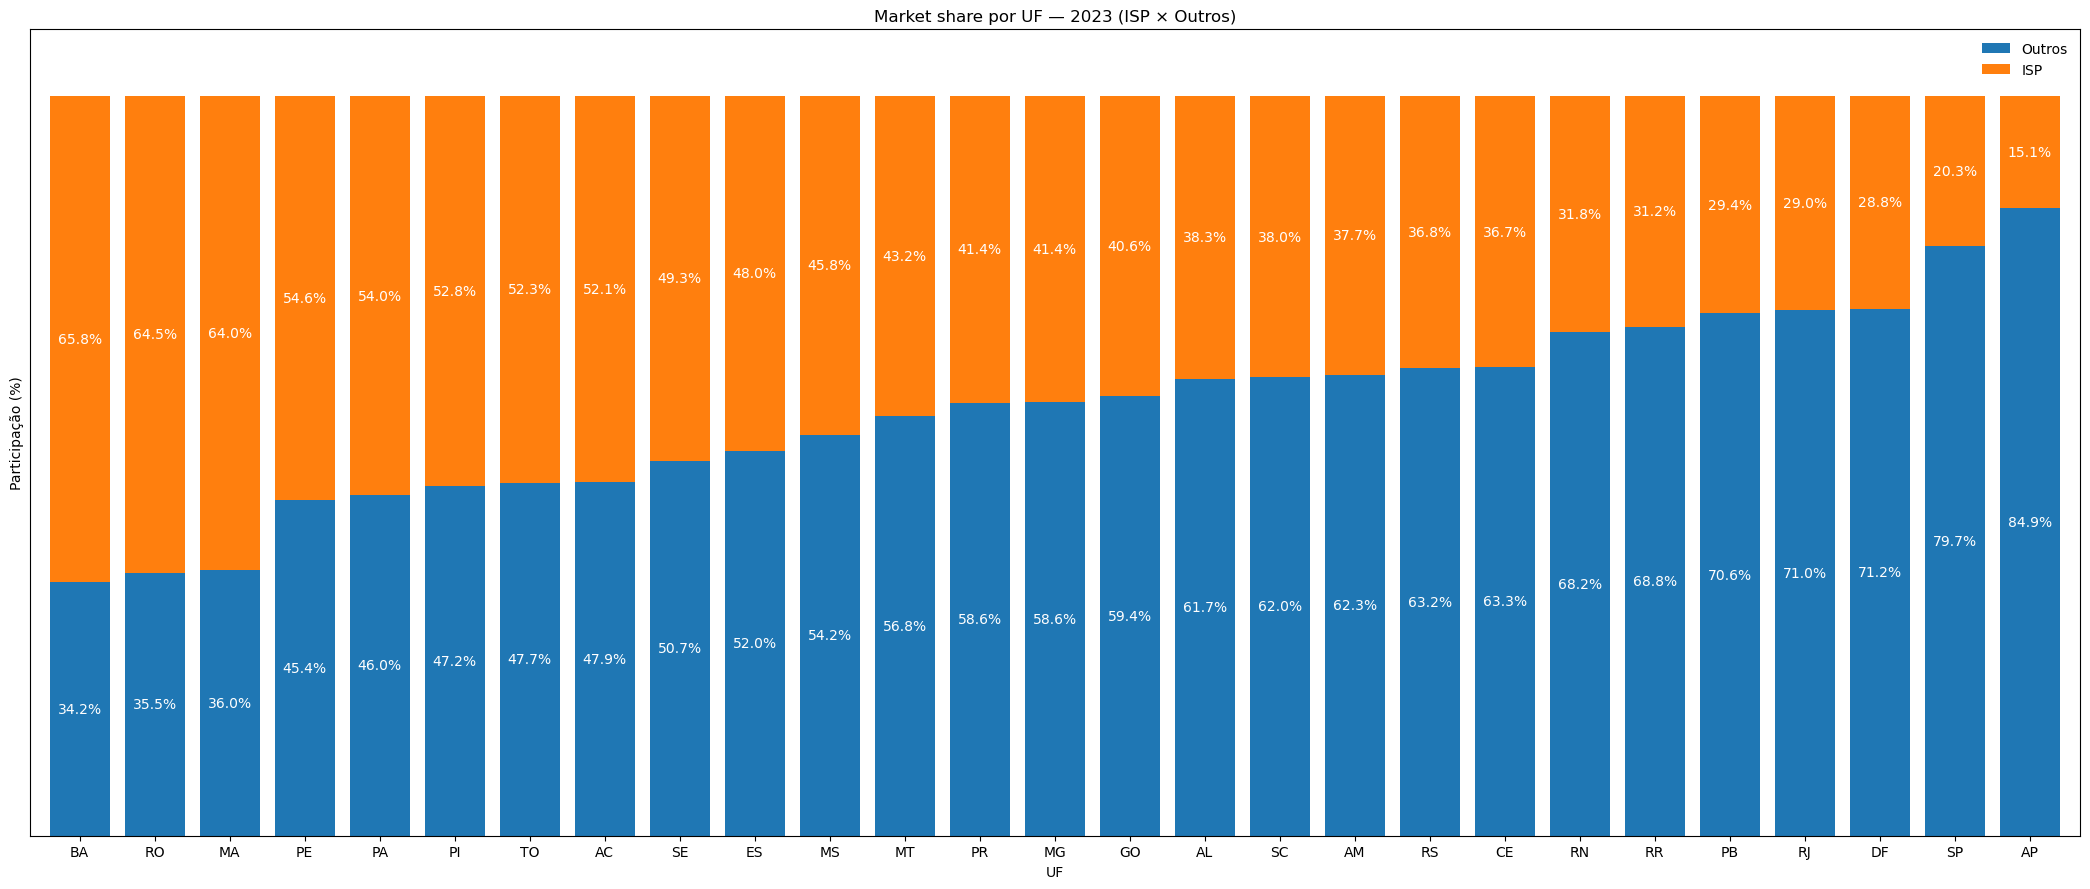

In [7]:
# 3) Market share por UF/ano — total e ISPs
sql_mshare = """
WITH total AS (
  SELECT uf, ano, SUM(banda_larga) AS assin_total
  FROM anatel_raw
  GROUP BY 1,2
),
por_grupo AS (
  SELECT uf, ano, UPPER(TRIM(grupo_economico)) AS grupo_economico, SUM(banda_larga) AS assin_grupo
  FROM anatel_raw
  GROUP BY 1,2,3
)
SELECT
  p.uf, p.ano, p.grupo_economico, p.assin_grupo, t.assin_total,
  CASE WHEN t.assin_total>0 THEN 100.0 * p.assin_grupo / t.assin_total END AS market_share_pct
FROM por_grupo p
JOIN total t USING (uf, ano)
ORDER BY ano DESC, uf, market_share_pct DESC;
"""
df_mshare = con.execute(sql_mshare).df()

# Filtra 2023 e normaliza grupo
df_2023 = df_mshare[df_mshare["ano"] == 2023].copy()
df_2023["grupo_economico"] = df_2023["grupo_economico"].str.upper().str.strip()

# Share do ISP por UF
isp = (
    df_2023[df_2023["grupo_economico"] == "ISP"]
    .groupby("uf", as_index=False)["market_share_pct"].sum()
    .rename(columns={"market_share_pct": "ISP"})
)

# Conjunto completo de UFs presentes em 2023
all_ufs = sorted(df_2023["uf"].dropna().unique())  # ordem alfabética

# Reindexa para garantir todas as UFs e calcula "Outros", ordena por ISP
isp = isp.set_index("uf").reindex(all_ufs, fill_value=0).reset_index()
isp["OUTROS"] = (100 - isp["ISP"]).clip(lower=0, upper=100)
isp = isp.sort_values(by="ISP", ascending=False)  # Ordena por ISP

# --- Plot: barras empilhadas (percentual) ---
plt.figure(figsize=(21, 9))
bars_outros = plt.bar(isp["uf"], isp["OUTROS"], label="Outros")  # legenda
bars_isp = plt.bar(isp["uf"], isp["ISP"], bottom=isp["OUTROS"], label="ISP")

# Adiciona porcentagens dentro das barras
for bars in [bars_outros, bars_isp]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Apenas se houver altura para evitar sobreposição
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                     f'{height:.1f}%',
                     ha='center', va='center', rotation=0, color='white', fontsize=10)

# Remove os valores do eixo y
plt.yticks([])

plt.title("Market share por UF — 2023 (ISP × Outros)")
plt.ylabel("Participação (%)")
plt.xlabel("UF")
plt.grid(True, axis="y", alpha=0.25)
plt.xticks(rotation=0)

# Ajusta as margens para reduzir o padding
plt.margins(x=0.01, y=0.09)  # Reduz a margem horizontal
plt.tight_layout()

# Legenda clara com rótulos definidos nos bars
plt.legend(loc="upper right", frameon=False)

plt.show()

In [8]:
# 4) Tamanho do player ISP — assinantes totais + nº de municípios atendidos (2023)

sql_size = """
WITH base AS (
  SELECT
    UPPER(TRIM(grupo_economico)) AS grupo_economico,
    UPPER(TRIM(empresa)) AS empresa,
    cod_mun, ano, SUM(banda_larga) AS assin
  FROM anatel_isp
  WHERE ano = 2023
  GROUP BY 1,2,3,4
)
SELECT
  empresa,
  SUM(assin) AS assinantes_2023,
  COUNT(DISTINCT cod_mun) AS n_municipios
FROM base
GROUP BY 1
ORDER BY assinantes_2023 DESC
LIMIT 50;
"""
df_size = con.execute(sql_size).df()
df_size.style.format({"assinantes_2023": pct_formatada})
df_size.head(10)


,empresa,assinantes_2023,n_municipios
0,STARLINK BRAZIL SERVICOS DE INTERNET LTDA.,902205.0,4710
1,LINQ TELECOMUNICACOES LTDA,610500.0,3
2,TECNOSERVE PROVEDORES DIGITAIS LTDA,591446.0,11
3,AGE TELECOMUNICACOES LTDA,586239.0,1
4,R7 TELECOMUNICACOES LTDA,580951.0,20
5,ZAMIX MULTIPLAY TELECOMUNICACOES LTDA,580442.0,24
6,HE-NET TELECOMUNICACOES LTDA,579127.0,26
7,DIGITAL NET INTERNET SERVICE PROVIDER LTDA ME,559540.0,6
8,ALLREDE TELECOM LTDA,546903.0,122
9,GGNET TELECOMUNICAÇÕES LTDA EPP,530971.0,262


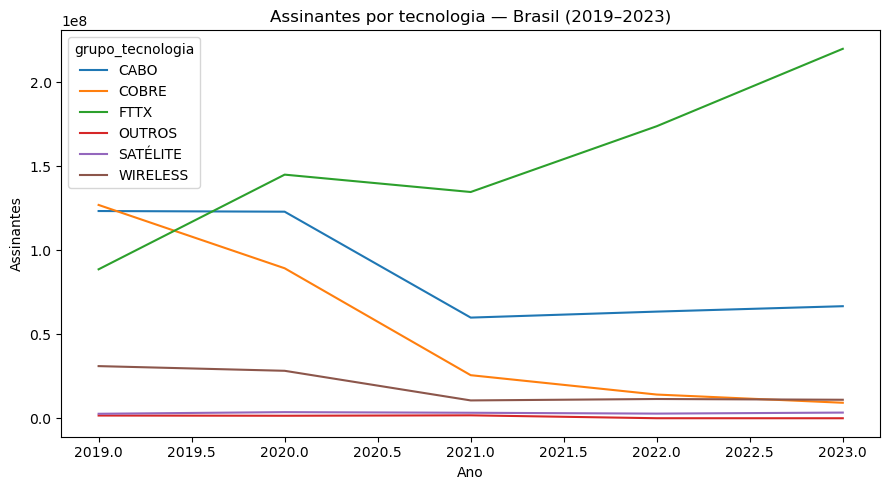

In [9]:
# 5) Crescimento por tecnologia (Brasil) 2019→2023
df_tec_br = con.execute("""
WITH agg AS (
  SELECT ano, grupo_tecnologia, SUM(banda_larga) AS assin
  FROM anatel_raw
  WHERE ano BETWEEN 2019 AND 2023
  GROUP BY 1,2
)
SELECT * FROM agg ORDER BY grupo_tecnologia, ano;
""").df()

pivot = df_tec_br.pivot(index='ano', columns='grupo_tecnologia', values='assin')
ax = pivot.plot(figsize=(9,5))
plt.title("Assinantes por tecnologia — Brasil (2019–2023)")
plt.xlabel("Ano"); plt.ylabel("Assinantes"); plt.tight_layout(); plt.show()

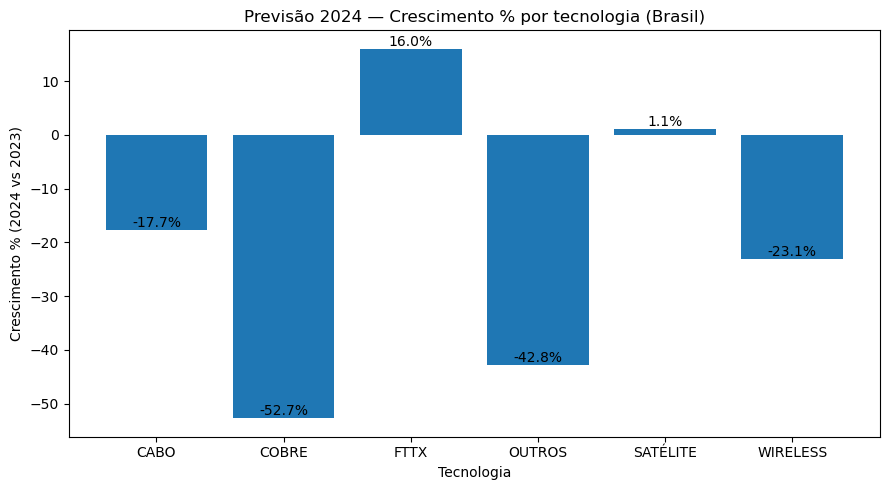

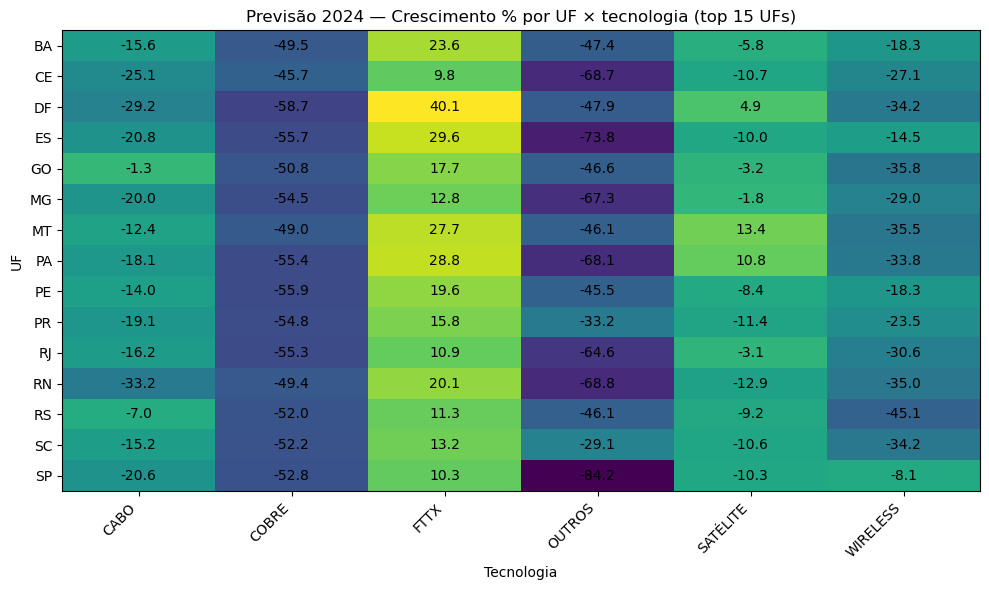

In [11]:
# 6) Forecast 2024: aplica CAGR (2020→2023) por UF × tecnologia na base de 2023
sql_fc = """
-- 1) Soma acessos por UF/ano/tecnologia para o período 2020..2023
WITH agg AS (
  SELECT uf, ano, grupo_tecnologia, SUM(banda_larga) AS assin
  FROM anatel_raw
  WHERE ano BETWEEN 2020 AND 2023
  GROUP BY 1,2,3
),
-- 2) Traz as bases de 2020 e 2023 lado a lado por UF × tecnologia
pvt AS (
  SELECT
    uf, grupo_tecnologia,
    SUM(CASE WHEN ano=2020 THEN assin ELSE 0 END) AS a2020,
    SUM(CASE WHEN ano=2023 THEN assin ELSE 0 END) AS a2023
  FROM agg
  GROUP BY 1,2
),
-- 3) Calcula o CAGR anualizado 2020→2023 (3 intervalos)
cagr AS (
  SELECT
    uf, grupo_tecnologia, a2020, a2023,
    CASE WHEN a2020>0 THEN POWER(a2023*1.0/a2020, 1.0/3) - 1 END AS cagr_2020_2023
  FROM pvt
),
-- 4) Base com os valores de 2023
base_2023 AS (
  SELECT uf, grupo_tecnologia, SUM(banda_larga) AS assin_2023
  FROM anatel_raw
  WHERE ano=2023
  GROUP BY 1,2
)
-- 5) Junta: aplica CAGR sobre a base 2023 para estimar 2024
SELECT
  b.uf, b.grupo_tecnologia,
  b.assin_2023,
  c.cagr_2020_2023,
  ROUND(b.assin_2023 * (1 + COALESCE(c.cagr_2020_2023,0))) AS forecast_2024
FROM base_2023 b
LEFT JOIN cagr c USING (uf, grupo_tecnologia)
ORDER BY b.uf, b.grupo_tecnologia;
"""
df_fc = con.execute(sql_fc).df()
df_fc.head(20)

# -------- Gráfico 1: Brasil por tecnologia (crescimento % 2024 vs 2023) --------
br_tec = (
    df_fc.groupby("grupo_tecnologia", as_index=False)[["assin_2023","forecast_2024"]].sum()
)
br_tec["crescimento_pct"] = (br_tec["forecast_2024"]/br_tec["assin_2023"] - 1) * 100

plt.figure(figsize=(9,5))
# barras do crescimento %
plt.bar(br_tec["grupo_tecnologia"], br_tec["crescimento_pct"])
plt.title("Previsão 2024 — Crescimento % por tecnologia (Brasil)")
plt.ylabel("Crescimento % (2024 vs 2023)")
plt.xlabel("Tecnologia")
# rótulos sobre as barras
for x, y in zip(br_tec["grupo_tecnologia"], br_tec["crescimento_pct"]):
    plt.text(x, y, f"{y:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# -------- Gráfico 2: Heatmap UF x tecnologia (top 15 UFs por base 2023) --------
df_fc = df_fc.copy()
df_fc["crescimento_pct"] = (df_fc["forecast_2024"]/df_fc["assin_2023"] - 1) * 100

# Seleciona top 15 UFs por base 2023 (soma das tecnologias)
ufs_top = (
    df_fc.groupby("uf", as_index=False)["assin_2023"].sum()
    .sort_values("assin_2023", ascending=False)
    .head(15)["uf"]
    .tolist()
)
sub = df_fc[df_fc["uf"].isin(ufs_top)]

# Pivot para heatmap (linhas: UF, colunas: tecnologia)
heat = sub.pivot_table(
    index="uf", columns="grupo_tecnologia",
    values="crescimento_pct", aggfunc="mean"
).sort_index()

plt.figure(figsize=(10,6))
plt.imshow(heat.values, aspect="auto")  # usa colormap padrão
plt.title("Previsão 2024 — Crescimento % por UF × tecnologia (top 15 UFs)")
plt.xlabel("Tecnologia")
plt.ylabel("UF")
# ticks
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)
# anota valores (opcional, com 1 decimal)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        val = heat.values[i, j]
        if pd.notnull(val):
            plt.text(j, i, f"{val:.1f}", ha="center", va="center")
plt.tight_layout()
plt.show()


In [12]:
# 7) ISPs-alvo
# Critérios:
# - >= 50 mil assinantes (2023)
# - >= 50 municípios (2023)
# - crescimento absoluto 2019→2023 > 20%
# - CAGR 2019→2023 >= 9% a.a.
# - mix de FIBRA (meio_de_acesso='FIBRA') em 2023 >= 50%

isps_alvo = """
-- 1. agregação por empresa, ano e meio_de_acesso
WITH base AS (  
  SELECT
    UPPER(TRIM(grupo_economico)) AS grupo_economico,
    UPPER(TRIM(empresa))         AS empresa,
    ano,
    UPPER(TRIM(meio_de_acesso))  AS meio_de_acesso,
    SUM(banda_larga)             AS assin
  FROM anatel_isp
  WHERE ano BETWEEN 2019 AND 2023
  GROUP BY 1,2,3,4
),
-- 2. totais e fibra por empresa/ano
split AS (   
  SELECT
    empresa,
    ano,
    SUM(assin)                                           AS assin_total,
    SUM(CASE WHEN meio_de_acesso='FIBRA' THEN assin ELSE 0 END) AS assin_fibra -- total de fibra no ano
  FROM base
  GROUP BY 1,2
),
-- 3. consolida 2019 e 2023
pvt1 AS (       
  SELECT
    empresa,
    SUM(CASE WHEN ano=2019 THEN assin_total ELSE 0 END) AS a2019,
    SUM(CASE WHEN ano=2023 THEN assin_total ELSE 0 END) AS a2023,
    SUM(CASE WHEN ano=2023 THEN assin_fibra ELSE 0 END) AS fibra_2023
  FROM split
  GROUP BY 1
),
-- 4. nº de municípios atendidos em 2023
footprint AS (  
  SELECT
    UPPER(TRIM(empresa)) AS empresa,
    COUNT(DISTINCT cod_mun) AS n_municipios
  FROM anatel_isp
  WHERE ano=2023
  GROUP BY 1
)
-- 5. Seleção final com métricas e filtros
SELECT
  p.empresa,
  p.a2019,
  p.a2023,
  (p.a2023 - p.a2019) AS crescimento_abs,
  CASE WHEN p.a2019>0 THEN printf('%.2f%%', POWER(p.a2023*1.0/p.a2019, 1.0/4) - 1) END AS cagr_aa,
  CASE WHEN p.a2023>0 THEN printf('%.2f%%', 100.0 * p.fibra_2023 / p.a2023) END AS fibra_share_2023_pct,
  f.n_municipios
FROM pvt1 p
LEFT JOIN footprint f USING (empresa)
WHERE p.a2023 >= 50000
  AND p.a2019 >= 100
  AND f.n_municipios >= 50
  AND (p.a2023 - p.a2019) > 0.20 * p.a2019
  AND (CASE WHEN p.a2019>0 THEN POWER(p.a2023*1.0/p.a2019, 1.0/4) - 1 END) >= 0.9
  AND (CASE WHEN p.a2023>0 THEN 100.0 * p.fibra_2023 / p.a2023 END) >= 50
ORDER BY p.a2023 DESC;
"""

df_short = con.execute(isps_alvo).df()
display(df_short)


,empresa,a2019,a2023,crescimento_abs,cagr_aa,fibra_share_2023_pct,n_municipios
0,ALLREDE TELECOM LTDA,33463.0,546903.0,513440.0,1.01%,99.41%,122
1,TELECAB TELECOMUNICACOES LTDA,12334.0,325621.0,313287.0,1.27%,96.73%,55
2,FAXT TELECOMUNICAÇÕES LTDA,6915.0,202807.0,195892.0,1.33%,97.21%,53
3,NORTE.NET TELECOMUNICACOES LTDA,3402.0,100205.0,96803.0,1.33%,90.65%,97
4,EQUATORIAL TELECOMUNICAÇÕES S.A.,852.0,58351.0,57499.0,1.88%,99.99%,144


In [13]:
## 8) Domicílios com e sem internet (Brasil, base 2023) + % formatadas

ANO_REF = 2023  # ajuste se quiser outro ano

sql = f"""
-- 1. Agrega assinantes por município no ano de referência
WITH assin_mun AS (
  SELECT
    cod_mun,
    SUM(banda_larga) AS assinantes
  FROM anatel_raw
  WHERE ano = {ANO_REF}
  GROUP BY cod_mun
),
-- 2. Seleciona domicílios totais do IBGE por município
ibge AS (
  SELECT
    cod_mun::INT AS cod_mun,
    dom_tot::BIGINT AS dom_tot
  FROM ibge_raw
)
-- 3. Cálculo agregado no nível Brasil
SELECT
  SUM(dom_tot) AS dom_tot_brasil,
  SUM(LEAST(COALESCE(a.assinantes,0), COALESCE(i.dom_tot,0))) AS dom_com_internet,
  SUM(GREATEST(COALESCE(i.dom_tot,0) - LEAST(COALESCE(a.assinantes,0), COALESCE(i.dom_tot,0)), 0)) AS dom_sem_internet
FROM ibge i
LEFT JOIN assin_mun a USING (cod_mun);
"""

df_br = con.execute(sql).df()

# Extrai valores totais do resultado
tot = int(df_br.loc[0, "dom_tot_brasil"])
com = int(df_br.loc[0, "dom_com_internet"])
sem = int(df_br.loc[0, "dom_sem_internet"])

# Percentuais
pct_com = (com / tot * 100) if tot else 0.0
pct_sem = (sem / tot * 100) if tot else 0.0

# Função para formatar % com vírgula
def fmt_pct(x):
    return f"{x:.2f}%".replace(".", ",")

resumo = pd.DataFrame([{
    "Ano": ANO_REF,
    "Domicílios totais (dom_tot)": f"{tot:,}".replace(",", "."),
    "Com internet (estimado)": f"{com:,}".replace(",", "."),
    "Sem internet (estimado)": f"{sem:,}".replace(",", "."),
    "% com internet": fmt_pct(pct_com),
    "% sem internet": fmt_pct(pct_sem),
}])

display(resumo)


,Ano,Domicílios totais (dom_tot),Com internet (estimado),Sem internet (estimado),% com internet,% sem internet
0,2023,90.688.021,86.874.349,3.813.672,"95,79%","4,21%"


In [14]:
# 9) Sumário: principais tabelas para o relatório

# 1. Top 10 UFs por crescimento absoluto de acessos (2017→2023)
print("Top 10 UFs por crescimento absoluto 2017→2023 (todos os players):")
print(con.execute("""
WITH agg AS (
  SELECT uf, ano, SUM(banda_larga) AS assin FROM anatel_raw WHERE ano IN (2017,2023) GROUP BY 1,2
),
-- Pivot: traz acessos de 2017 e 2023 lado a lado por UF
pvt AS (
  SELECT uf,
         SUM(CASE WHEN ano=2017 THEN assin ELSE 0 END) AS a2017,
         SUM(CASE WHEN ano=2023 THEN assin ELSE 0 END) AS a2023
  FROM agg GROUP BY 1
)
-- Calcula crescimento absoluto e seleciona Top 10 UFs
SELECT uf, a2017, a2023, (a2023-a2017) AS crescimento_abs
FROM pvt WHERE a2017>0 AND a2023>0
ORDER BY crescimento_abs DESC LIMIT 10;
""").df())

## 2. CAGR 2019→2023 por tecnologia 
print("\nCAGR 2019→2023 por tecnologia — Brasil:")
print(con.execute("""
-- Soma acessos por ano e tecnologia (Brasil)
WITH agg AS (
  SELECT ano, grupo_tecnologia, SUM(banda_larga) AS assin
  FROM anatel_raw WHERE ano BETWEEN 2019 AND 2023 GROUP BY 1,2
),
-- Pivot: traz acessos de 2019 e 2023 por tecnologia
pvt AS (
  SELECT grupo_tecnologia,
         SUM(CASE WHEN ano=2019 THEN assin ELSE 0 END) AS a2019,
         SUM(CASE WHEN ano=2023 THEN assin ELSE 0 END) AS a2023
  FROM agg GROUP BY 1
)
-- Calcula crescimento absoluto e CAGR 2019→2023
SELECT grupo_tecnologia, a2019, a2023,
       (a2023-a2019) AS crescimento_abs,
       CASE WHEN a2019>0 THEN POWER(a2023*1.0/a2019, 1.0/4) - 1 END AS CAGR
FROM pvt ORDER BY CAGR DESC NULLS LAST;
""").df().round(4))

print("\nShort-list de ISPs recomendados (regras simples):")
display(df_short.head(15))


Top 10 UFs por crescimento absoluto 2017→2023 (todos os players):
   uf       a2017       a2023  crescimento_abs
0  MG  27857616.0  34295439.0        6437823.0
1  SC  13014145.0  17940816.0        4926671.0
2  BA   9678115.0  13123396.0        3445281.0
3  CE   7758843.0  10923016.0        3164173.0
4  RS  18162766.0  21182524.0        3019758.0
5  PR  20328328.0  22634608.0        2306280.0
6  PA   3172180.0   5386634.0        2214454.0
7  MA   2414768.0   4424824.0        2010056.0
8  AM   1975350.0   3667213.0        1691863.0
9  PE   5979137.0   7569428.0        1590291.0

CAGR 2019→2023 por tecnologia — Brasil:
  grupo_tecnologia        a2019        a2023  crescimento_abs    CAGR
0             FTTX   88695664.0  219892941.0      131197277.0  0.2548
1         SATÉLITE    2740392.0    3445408.0         705016.0  0.0589
2             CABO  123368818.0   66740694.0      -56628124.0 -0.1424
3         WIRELESS   31089860.0   11075154.0      -20014706.0 -0.2274
4            COBRE  126988

,empresa,a2019,a2023,crescimento_abs,cagr_aa,fibra_share_2023_pct,n_municipios
0,ALLREDE TELECOM LTDA,33463.0,546903.0,513440.0,1.01%,99.41%,122
1,TELECAB TELECOMUNICACOES LTDA,12334.0,325621.0,313287.0,1.27%,96.73%,55
2,FAXT TELECOMUNICAÇÕES LTDA,6915.0,202807.0,195892.0,1.33%,97.21%,53
3,NORTE.NET TELECOMUNICACOES LTDA,3402.0,100205.0,96803.0,1.33%,90.65%,97
4,EQUATORIAL TELECOMUNICAÇÕES S.A.,852.0,58351.0,57499.0,1.88%,99.99%,144


## Conclusões & Recomendações

**Mercado & Tecnologia**
- Fibra lidera o crescimento de 32,80% de participação para 51,98% de participação em 2022
- Regiões com maior aceleração(CARG): Norte: 14,85%, sul: 9,82%, Sudeste: 3,94%, Nordeste: 2,46%, Centro-Oeste: 2,39%.

**Perfil dos ISPs**
- ISPs com > X mil assinantes e presença em ≥ Y municípios têm melhor escala.
- Mix de fibra ≥ 60% correlaciona com maiores taxas de crescimento.

**Short-list de aquisições (2023)**
- Critérios: base ≥ 50k, ≥ 30 municípios, CAGR ≥ 10% a.a., fibra ≥ 60%.
- Candidatos: <3–5 nomes com números-chave>.

**Próximos passos**
- Refinar forecast com modelos (ARIMA/Prophet/regressão), variáveis macro (renda, densidade domicílios).
- Due diligence nos ISPs shortlist: churn, ARPU, capilaridade, qualidade de rede (latência/velocidade).
